# Iris dataset classification with Python

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns            # pretty visualisations
import matplotlib.pyplot as plt  # plotting

from sklearn.datasets import load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline  

In [146]:
# load the dataset, description
iris = load_iris()
print(iris['DESCR'])

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

## Task

Predict class of an unseen flower.

## Load data into a dataframe

In [147]:
data = pd.DataFrame(iris['data'], columns=iris['feature_names'])
data['target'] = iris['target']

In [148]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## EDA

Spot anomalies; visualise and identify patterns; and beging to formulate hypothesis.

__Are there missing values?__

In [149]:
data.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

__Generate summary statistics.__

In [150]:
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


__Visualise the data.__

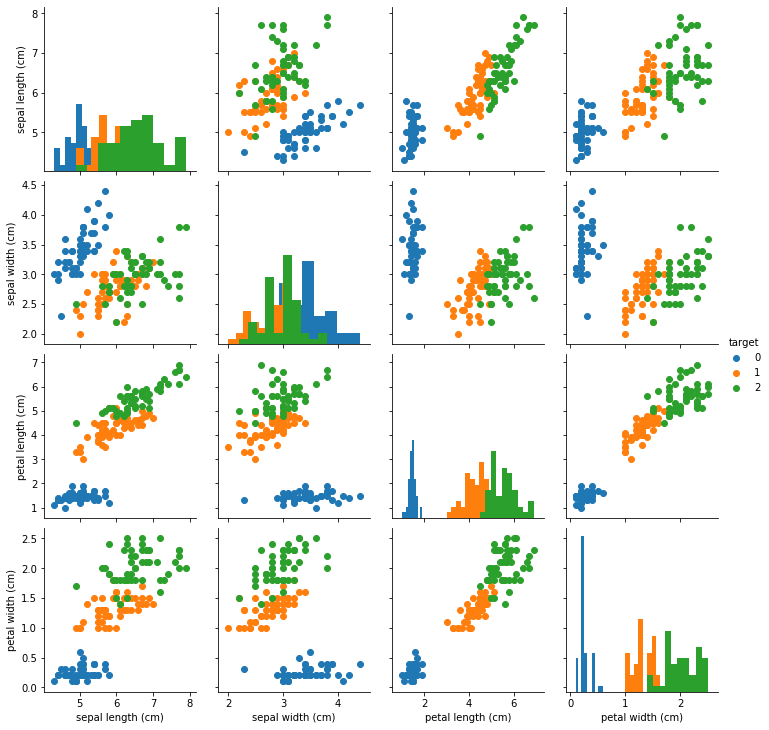

In [151]:
g = sns.PairGrid(data, hue='target')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

## Build the model

### 1. Split `data` into train and test sets

In [152]:
X = data.values[:,0:4]
Y = np.ravel(data['target'], order='C')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [153]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(120, 4)
(120,)
(30, 4)
(30,)


### 2. Score the model

Score some classification models and pick the best one.

In [154]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC())) 

In [155]:
# validate with stratified kfold cross-validation
scores = []
names = []
for name, model in models:
    # choose 10 folds
    kFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cvResults = cross_val_score(model, X_train, Y_train, cv=kFold, scoring='accuracy')
    scores.append(cvResults)
    names.append(name)
    # mean and the 95% confidence interval of cv_result estimate given by:
    print("Accuracy of %s: %0.5f (+/- %0.5f)" % (name, cvResults.mean(), cvResults.std() * 2))

Accuracy of LR: 0.95591 (+/- 0.08867)
Accuracy of LDA: 0.97564 (+/- 0.07449)
Accuracy of KNN: 0.95052 (+/- 0.08113)
Accuracy of CART: 0.95886 (+/- 0.10751)
Accuracy of NB: 0.95117 (+/- 0.10562)
Accuracy of SVC: 0.98333 (+/- 0.06667)


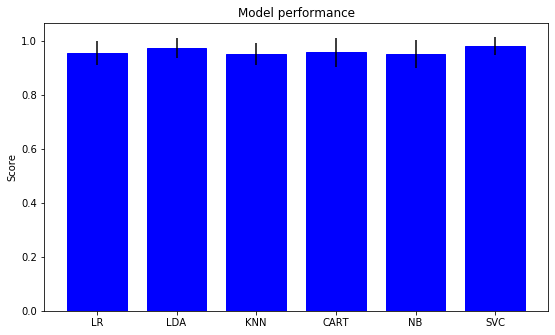

In [156]:
fig = plt.figure(figsize=(7,4))
ax = plt.axes([0,0,1,1])
means = [i.mean() for i in scores]
stdevs = [i.std() for i in scores]
ax.bar(names, means, yerr=stdevs, color='blue', width=.75, edgecolor='blue')
ax.set_ylabel('Score')
ax.set_title('Model performance');

### 3. Tune hyperparameters

In [157]:
# parameters to fit
cValues = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernelValues = ['linear', 'poly', 'rbf', 'sigmoid']
paramGrid = dict(C=cValues, kernel=kernelValues)

In [158]:
# build the model
model = SVC()
kFold = StratifiedKFold(n_splits=10, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=paramGrid, scoring='accuracy', cv=kFold)
gridResult = grid.fit(X_train, Y_train)

In [159]:
# display the results
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']

Best: 0.983333 using {'C': 0.3, 'kernel': 'linear'}


## Fit the model

Choose a support vector classifier that separates points with a plane.

In [160]:
model = SVC(C=0.3, kernel='linear')
model.fit(X_train, Y_train)

SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Make predictions

In [161]:
predictions = model.predict(X_test)

In [162]:
print("Accuracy of %f " % (accuracy_score(Y_test, predictions)*100))
print(confusion_matrix(Y_test, predictions))

Accuracy of 96.666667 
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
